In [192]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from minisom import MiniSom
import pickle
import os

In [193]:
df_L3_info = Table.read('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_info.fits')
df_L3_info = df_L3_info.to_pandas()

In [194]:
L3_phot_data = np.loadtxt('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_averaged_phot102.txt')
phot_data = L3_phot_data[:,3::2]
phot_err_data = L3_phot_data[:,4::2]

In [ ]:
plt.hist(df_L3_info["z_true"], bins = 20)
plt.show()

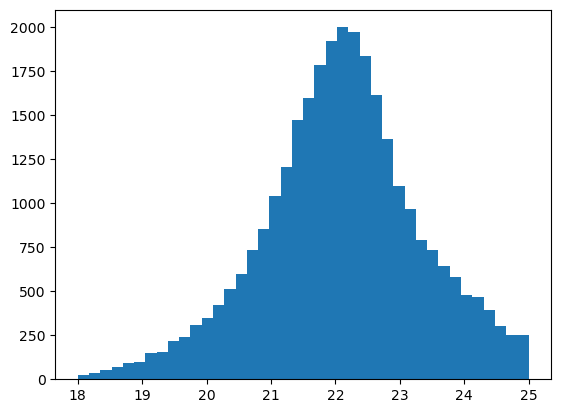

In [184]:
plt.hist(df_L3_info["HSC_i_MAG"], bins = 40)
plt.show()

In [219]:
def remove_low_SNR(data, data_err, info_data, mode, mag_cut):
    i_band = info_data["HSC_i_MAG"].values
    if mode == "mag_cut" or mode == "both":
        if type(mag_cut) == type(1):
            max_cut = np.mean(i_band) - np.std(i_band, ddof = 1) * mag_out
            data = data[i_band < max_cut]
            data_err = data[i_band < max_cut]
            info_data = info_data[np.logical_and((i_band < mag_cut[1]), (i_band > mag_cut[0]))]
        else:
            data = data[np.logical_and((i_band < mag_cut[1]), (i_band > mag_cut[0]))]
            data_err = data_err[np.logical_and((i_band < mag_cut[1]), (i_band > mag_cut[0]))]
            info_data = info_data[np.logical_and((i_band < mag_cut[1]), (i_band > mag_cut[0]))]
    if mode == "band_cut" or mode == "both":
        data = data[:, : len(data[0]) - 34]
        data_err = data_err[:, : len(data_err[0]) - 34]
        
    return data, data_err, info_data

In [220]:
def preprocess(data, data_err, mode):
    if mode == "default":
        proc_data = (data - np.mean(data, axis=0)) / np.std(data, ddof = 1, axis=0)
    elif mode == "SNR":
        proc_data = data / data_err
        proc_data = (proc_data - np.mean(proc_data, axis=0)) / np.std(proc_data, ddof = 1, axis=0)
    return proc_data

In [221]:
def basic_som(data, info_data, dim, cmap, preproc, iteration = 1, sigma = 1, learning_rate = 1):
    som = MiniSom(dim, dim, data.shape[1], sigma = sigma, learning_rate = learning_rate)
    som.random_weights_init(data)
    som.train(data, iteration, use_epochs = True)

    print("Finish traininging SOM.")
    print("Start making diagrams...")

    density_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map.fill(np.nan)
    z_map = np.zeros(dim ** 2).reshape(dim, dim)
    z_map.fill(np.nan)
    
    labels_map_1 = som.labels_map(data, [0] * len(data))
    labels_map_2 = som.labels_map(data, tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), np.expand_dims(info_data["z_true"].values, axis = 1)), axis = -1))))

    for i in labels_map_1.keys():
        density_map[int(list(i)[0]), int(list(i)[1])] = labels_map_1[i][0]

    print("Finish collecting data for density map.")
    
    for i in labels_map_2.keys():
        properties = np.mean(np.array(list(labels_map_2[i].keys())), axis = 0)
        magnitude_map[int(list(i)[0]), int(list(i)[1])] = properties[0]
        z_map[int(list(i)[0]), int(list(i)[1])] = properties[1]

    print("Finish collecting data for magnitude map.")

    print(f"Topological error: {som.topographic_error(data)}")
    print(f"Quantization error: {som.quantization_error(data)}")

    %matplotlib inline
    plt.close()
    plt.figure(figsize = (25, 25))
    plt.subplot(221)
    plt.pcolor(som.distance_map().T, cmap='YlGn')  # plotting the distance map as background
    plt.colorbar()
    plt.title("Distance map (U-matrix)")

    plt.subplot(222)
    plt.pcolor(density_map.T, cmap='YlGn')
    plt.colorbar()
    plt.title("Density Map")

    plt.subplot(223)
    plt.pcolor(magnitude_map.T, cmap="plasma" + "_r")
    plt.colorbar()
    plt.title("HSC I Magnitude Map")

    plt.subplot(224)
    plt.pcolor(z_map.T, cmap="jet")
    plt.colorbar()
    plt.title("True Redshift Map")

    plt.show()

    if os.path.isfile("D:/SPHEREx_SOM/record/preliminary_exploration/record.pkl"):
        with open("D:/SPHEREx_SOM/record/preliminary_exploration/record.pkl", "rb") as fh:
            record = pickle.load(fh)
    else:
        record = []

    map_record = {}
    map_record["dim"] = dim
    map_record["sigma"] = sigma
    map_record["rate"] = learning_rate
    map_record["band_cut"] = len(data[0])
    map_record["mag_cut"] = len(data)
    map_record["preproc"] = preproc
    map_record["som"] = som
    map_record["topo_err"] = som.topographic_error(data)
    map_record["quan_err"] = som.quantization_error(data)
    map_record["demsity"] = density_map
    map_record["magnitude"] = magnitude_map
    map_record["z"] = z_map

    record.append(map_record)
    
    with open("D:/SPHEREx_SOM/record/preliminary_exploration/record.pkl", "wb") as fh:
        pickle.dump(record, fh)
    
    return som

In [222]:
data, data_err, info_data = remove_low_SNR(data = phot_data, data_err = phot_err_data, info_data = df_L3_info, mode = "both", mag_cut = [0, 22])

In [223]:
proc_data = preprocess(data = data, data_err = data_err, mode = "SNR")

In [224]:
proc_data.shape

(13651, 68)

In [217]:
for i in range(1, 21):
    som = basic_som(data = proc_data, info_data = info_data, dim = 40, cmap = "viridis", sigma = 0.4, preproc = "SNR", learning_rate = i / 10)

Finish traininging SOM.
Start making diagrams...


ValueError: data and labels must have the same length.

In [ ]:
# som = MiniSom(100, 100, data.shape[1], sigma=  1, learning_rate = 1,
#               neighborhood_function='gaussian', random_seed=10)

# max_iter = 1000
# q_error = []
# t_error = []

# for i in range(max_iter):
#     rand_i = np.random.randint(len(data))
#     som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
#     q_error.append(som.quantization_error(data))
#     t_error.append(som.topographic_error(data))

# plt.plot(np.arange(max_iter), q_error, label='quantization error')
# plt.plot(np.arange(max_iter), t_error, label='topographic error')
# plt.ylabel('error')
# plt.xlabel('iteration index')
# plt.legend()
# plt.show()

In [122]:
with open("D:/SPHEREx_SOM/record/preliminary_exploration/record.pkl", "rb") as fh:
    record = pickle.load(fh)

In [ ]:
record